<a href="https://colab.research.google.com/github/sdave-connexion/Hierarical-sales-forecsting/blob/main/hts_sales_forecasting_9sept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# scikit-hts showcase: Sale prediction for  Feelgood and Joylift brand

In this showcase we are using historical data (3 years) for the companies Fealgood GmbH & Co.KG and SunnyTude Ltd. 
Main goal is to forecast sales and analyse the performance of both the brands for year 2021


In [1]:
#!pip install scikit-hts
#!pip install scikit-hts[auto_arima]
#!pip install scikit-hts[all]
#!pip install prophet

In [2]:
#for the hierarchy tree
import random

import numpy as np
import networkx as nx

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    G: the graph (must be a tree)
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    width: horizontal space allocated for this branch - avoids overlap with other branches
    vert_gap: gap between levels of hierarchy
    vert_loc: vertical location of root
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments
        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed
        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

def make_annotations(pos, font_size=10, font_color='rgb(250,250,250)', M=None):
    annotations = []
    for label, pos in pos.items():
        annotations.append(
            dict(
                text=label, # or replace labels with a different list for the text within the circle
                x=pos[0], y=2*M+pos[1],
                xref='x1', yref='y1',
                font=dict(color=font_color, size=font_size),
                showarrow=False)
        )
    return annotations

def get_nodes_edges_position(edges, root="total", **kargs):

    G = nx.Graph()
    G.add_edges_from(edges)

    positions = hierarchy_pos(G, root=root, width=10000)
    positions = {key:list(value) for key, value in positions.items()}

    nodes_x = [position[0] for position in positions.values()]
    nodes_y = [position[1] for position in positions.values()]

    M = max(nodes_y)
    edges_x = []
    edges_y = []

    for edge in edges:
        edges_x += [positions[edge[0]][0],positions[edge[1]][0], None]
        edges_y += [10*M+positions[edge[0]][1],10*M+positions[edge[1]][1], None]

    labels = list(positions.keys())
    annotations = make_annotations(positions, M=M)

    return nodes_x, nodes_y, edges_x, edges_y, labels, annotations

In [3]:
# Usual imports
import sys

sys.path.append("../src")
import os
from pprint import pprint
import importlib

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from pandas.core.common import SettingWithCopyWarning

import warnings

warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

%matplotlib inline
%load_ext autoreload
%autoreload 2

%matplotlib inline



## Loading Data

In [4]:
sales_insights = pd.read_csv('/content/raw_data.csv')
sales_insights.head(7)

,item_id,brand,brand_id,company,company_id,datetime,volume
0,1,Joylift,2,Fealgood GmbH & Co.KG,1,2019-01-01,460
1,1,Joylift,2,Fealgood GmbH & Co.KG,1,2019-02-01,408
2,1,Joylift,2,Fealgood GmbH & Co.KG,1,2019-03-01,457
3,1,Joylift,2,Fealgood GmbH & Co.KG,1,2019-04-01,348
4,1,Joylift,2,Fealgood GmbH & Co.KG,1,2019-05-01,302
5,1,Joylift,2,Fealgood GmbH & Co.KG,1,2019-06-01,288
6,1,Joylift,2,Fealgood GmbH & Co.KG,1,2019-07-01,332


**The hierarchy in this dataset is the following**

  -The brand of the company Fealgood GmbH & Co.KG is called Joylift and contains 16 products. 
  -The brand of the company SunnyTude Ltd. is called Sunnyside and contains 86 products.
 
So in order to produce unique bottom series, let's create a new column where we concatenate company and brand ID.

In [5]:
# inspect all the regions per state
sales_insights.groupby("brand")["item_id"].apply(set).to_frame()

,item_id
brand,
Joylift,"{1, 2, 34, 36, 99, 100, 75, 48, 80, 50, 20, 21..."
Sunnyside,"{3, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19..."


In [6]:
sales_insights["unique_bottom_id"] = sales_insights.apply(lambda x: f"{x['brand']}_{x['item_id']}", axis=1)

## Visualizing Tree Structure

Let's create a simple plot of our tree structure so we can develop a better understanding of our dataset. We will use networkx and plotly to produce the visualization, so we need to create a list of tuples for each connection.

In [7]:
grouped_sections = sales_insights.groupby(["brand", "unique_bottom_id"])
edges_hierarchy = list(grouped_sections.groups.keys())
edges_hierarchy[:]

[('Joylift', 'Joylift_1'),
 ('Joylift', 'Joylift_100'),
 ('Joylift', 'Joylift_2'),
 ('Joylift', 'Joylift_20'),
 ('Joylift', 'Joylift_21'),
 ('Joylift', 'Joylift_22'),
 ('Joylift', 'Joylift_23'),
 ('Joylift', 'Joylift_30'),
 ('Joylift', 'Joylift_34'),
 ('Joylift', 'Joylift_36'),
 ('Joylift', 'Joylift_48'),
 ('Joylift', 'Joylift_50'),
 ('Joylift', 'Joylift_75'),
 ('Joylift', 'Joylift_80'),
 ('Joylift', 'Joylift_99'),
 ('Sunnyside', 'Sunnyside_10'),
 ('Sunnyside', 'Sunnyside_11'),
 ('Sunnyside', 'Sunnyside_12'),
 ('Sunnyside', 'Sunnyside_14'),
 ('Sunnyside', 'Sunnyside_15'),
 ('Sunnyside', 'Sunnyside_16'),
 ('Sunnyside', 'Sunnyside_17'),
 ('Sunnyside', 'Sunnyside_19'),
 ('Sunnyside', 'Sunnyside_24'),
 ('Sunnyside', 'Sunnyside_26'),
 ('Sunnyside', 'Sunnyside_27'),
 ('Sunnyside', 'Sunnyside_28'),
 ('Sunnyside', 'Sunnyside_29'),
 ('Sunnyside', 'Sunnyside_3'),
 ('Sunnyside', 'Sunnyside_31'),
 ('Sunnyside', 'Sunnyside_32'),
 ('Sunnyside', 'Sunnyside_33'),
 ('Sunnyside', 'Sunnyside_35'),
 ('Sun

Now, we must not forget total that is our root node.

In [8]:
second_level_nodes = ["Sunnyside", "Joylift"]
root_node = "total"

root_edges = [(root_node, second_level_node) for second_level_node in second_level_nodes]
root_edges

[('total', 'Sunnyside'), ('total', 'Joylift')]

In [9]:
root_edges += edges_hierarchy

In [10]:
root_edges

[('total', 'Sunnyside'),
 ('total', 'Joylift'),
 ('Joylift', 'Joylift_1'),
 ('Joylift', 'Joylift_100'),
 ('Joylift', 'Joylift_2'),
 ('Joylift', 'Joylift_20'),
 ('Joylift', 'Joylift_21'),
 ('Joylift', 'Joylift_22'),
 ('Joylift', 'Joylift_23'),
 ('Joylift', 'Joylift_30'),
 ('Joylift', 'Joylift_34'),
 ('Joylift', 'Joylift_36'),
 ('Joylift', 'Joylift_48'),
 ('Joylift', 'Joylift_50'),
 ('Joylift', 'Joylift_75'),
 ('Joylift', 'Joylift_80'),
 ('Joylift', 'Joylift_99'),
 ('Sunnyside', 'Sunnyside_10'),
 ('Sunnyside', 'Sunnyside_11'),
 ('Sunnyside', 'Sunnyside_12'),
 ('Sunnyside', 'Sunnyside_14'),
 ('Sunnyside', 'Sunnyside_15'),
 ('Sunnyside', 'Sunnyside_16'),
 ('Sunnyside', 'Sunnyside_17'),
 ('Sunnyside', 'Sunnyside_19'),
 ('Sunnyside', 'Sunnyside_24'),
 ('Sunnyside', 'Sunnyside_26'),
 ('Sunnyside', 'Sunnyside_27'),
 ('Sunnyside', 'Sunnyside_28'),
 ('Sunnyside', 'Sunnyside_29'),
 ('Sunnyside', 'Sunnyside_3'),
 ('Sunnyside', 'Sunnyside_31'),
 ('Sunnyside', 'Sunnyside_32'),
 ('Sunnyside', 'Sunnys

Now that we have our dataset ready, let's define our hierarchy tree. We need a dictionary, where each key is a column (node) in our hierarchy and a list of its children.

In [11]:
hierarchy = dict()

for edge in root_edges:
    parent, children = edge[0], edge[1]
    hierarchy.get(parent)
    if not hierarchy.get(parent):
        hierarchy[parent] = [children]
    else:
        hierarchy[parent] += [children]

In [12]:
hierarchy

{'total': ['Sunnyside', 'Joylift'],
 'Joylift': ['Joylift_1',
  'Joylift_100',
  'Joylift_2',
  'Joylift_20',
  'Joylift_21',
  'Joylift_22',
  'Joylift_23',
  'Joylift_30',
  'Joylift_34',
  'Joylift_36',
  'Joylift_48',
  'Joylift_50',
  'Joylift_75',
  'Joylift_80',
  'Joylift_99'],
 'Sunnyside': ['Sunnyside_10',
  'Sunnyside_11',
  'Sunnyside_12',
  'Sunnyside_14',
  'Sunnyside_15',
  'Sunnyside_16',
  'Sunnyside_17',
  'Sunnyside_19',
  'Sunnyside_24',
  'Sunnyside_26',
  'Sunnyside_27',
  'Sunnyside_28',
  'Sunnyside_29',
  'Sunnyside_3',
  'Sunnyside_31',
  'Sunnyside_32',
  'Sunnyside_33',
  'Sunnyside_35',
  'Sunnyside_37',
  'Sunnyside_38',
  'Sunnyside_42',
  'Sunnyside_43',
  'Sunnyside_51',
  'Sunnyside_52',
  'Sunnyside_53',
  'Sunnyside_54',
  'Sunnyside_56',
  'Sunnyside_57',
  'Sunnyside_58',
  'Sunnyside_59',
  'Sunnyside_6',
  'Sunnyside_60',
  'Sunnyside_61',
  'Sunnyside_62',
  'Sunnyside_63',
  'Sunnyside_64',
  'Sunnyside_65',
  'Sunnyside_66',
  'Sunnyside_67',


In [13]:
Xn, Yn, Xe, Ye, labels, annot = get_nodes_edges_position(root_edges, root="total")
M = max(Yn)

fig = go.Figure()

fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgb(210,210,210)', width=1),
                   hoverinfo='none'
                   ))

fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  name='bla',
                  marker=dict(symbol='circle-dot',
                                size=30,
                                color='#6175c1',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  text=labels,
                  hoverinfo='text',
                  opacity=0.8
                  ))

axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            )

fig.update_layout(title= 'Hierarchical Structure Tree for sales data of Joylift & Sunnytude',
              annotations=annot,
              font_size=10,
              showlegend=False,
              xaxis=axis,
              yaxis=axis,
              margin=dict(l=40, r=40, b=85, t=100),
              hovermode='closest',
              plot_bgcolor='rgb(248,248,248)'
              )
fig.show()

We can see above how our data is structured, now let's transform it in order to use scikit-hts properly.

## Transform data in the format required by scikit-hts

*scikit-hts* requires that each column in our DataFrame is a time series of its own, for all hierarchy levels.

The steps are the following:

1. Transform dataset into a column oriented one (from long format)
2. Create the hierarchy representation as a dictionary
 

In [14]:
from google.colab.data_table import DataTable
DataTable.max_columns = 100

In [15]:
sales_insights_bottom_level = sales_insights.pivot(index="datetime", columns="unique_bottom_id", values="volume")
sales_insights_bottom_level.head(5)

unique_bottom_id,Joylift_1,Joylift_100,Joylift_2,Joylift_20,Joylift_21,Joylift_22,Joylift_23,Joylift_30,Joylift_34,Joylift_36,...,Sunnyside_9,Sunnyside_90,Sunnyside_91,Sunnyside_92,Sunnyside_93,Sunnyside_94,Sunnyside_95,Sunnyside_96,Sunnyside_97,Sunnyside_98
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01,460.0,NaN,1298.0,2883.0,1743.0,5214.0,348.0,1387.0,3595.0,850.0,...,403.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,408.0,NaN,1279.0,2319.0,1663.0,4670.0,355.0,1140.0,3550.0,834.0,...,451.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01,457.0,NaN,1268.0,2694.0,1649.0,5277.0,404.0,1441.0,4061.0,816.0,...,862.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01,348.0,NaN,1083.0,2106.0,1613.0,4842.0,391.0,1337.0,3737.0,655.0,...,1738.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-01,302.0,NaN,1238.0,2308.0,1905.0,4919.0,302.0,1426.0,3388.0,737.0,...,2605.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#brands = sales_insights["brand"].unique()
#product = sales_insights["unique_bottom_id"].unique()

#total = {'total': list(brands)}
#brand = {k: [v for v in product if v.startswith(k)] for k in brands}
#hierarchy = {**total, **brand}

In [ ]:
#from hts.hierarchy import HierarchyTree
#ht = HierarchyTree.from_nodes(nodes=hierarchy, df=sales_insights_bottom_level)
#ht

We still need data aggregate by state and the total column.

In [18]:
def get_brand_columns(df, brand):
    return [col for col in df.columns if brand in col]

brands = sales_insights['brand'].unique().tolist()

for brand in brands:
    brand_cols = get_brand_columns(sales_insights_bottom_level, brand)
    sales_insights_bottom_level[brand] = sales_insights_bottom_level[brand_cols].sum(axis=1)

sales_insights_bottom_level['total'] = sales_insights_bottom_level[brands].sum(axis=1)

sales_insights_bottom_level.head(5)

unique_bottom_id,Joylift_1,Joylift_100,Joylift_2,Joylift_20,Joylift_21,Joylift_22,Joylift_23,Joylift_30,Joylift_34,Joylift_36,...,Sunnyside_92,Sunnyside_93,Sunnyside_94,Sunnyside_95,Sunnyside_96,Sunnyside_97,Sunnyside_98,Joylift,Sunnyside,total
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01,460.0,NaN,1298.0,2883.0,1743.0,5214.0,348.0,1387.0,3595.0,850.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21505.0,3936.0,25441.0
2019-02-01,408.0,NaN,1279.0,2319.0,1663.0,4670.0,355.0,1140.0,3550.0,834.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19438.0,5818.0,25256.0
2019-03-01,457.0,NaN,1268.0,2694.0,1649.0,5277.0,404.0,1441.0,4061.0,816.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21423.0,9546.0,30969.0
2019-04-01,348.0,NaN,1083.0,2106.0,1613.0,4842.0,391.0,1337.0,3737.0,655.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19049.0,20003.0,39052.0
2019-05-01,302.0,NaN,1238.0,2308.0,1905.0,4919.0,302.0,1426.0,3388.0,737.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19604.0,24114.0,43718.0


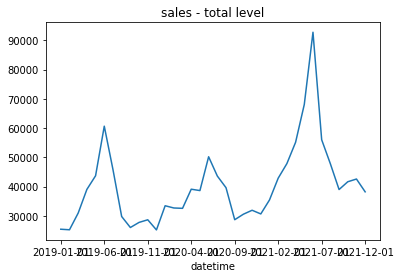

In [19]:
sales_insights_bottom_level["total"].plot(title="sales - total level");

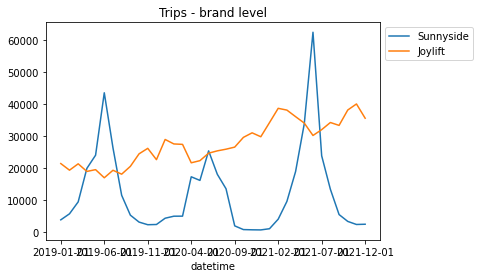

In [20]:
ax = sales_insights_bottom_level[hierarchy['total']].plot(title="Trips - brand level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

## Fitting our models

Let's fit a few different models in our data and compare results.

In [21]:
# Does not change anything in data, except for index to be QS
sales_insights_bottom_level.index = pd.to_datetime(sales_insights_bottom_level.index)
sales_insights_bottom_level = sales_insights_bottom_level.resample("MS").sum()

### Auto-Arima

First let's use scikit-hts to fit an ARIMA model specifically, the auto-arima implemented in the excellent pmdarima library.

In [22]:
from hts import HTSRegressor

clf = HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0)
model = clf.fit(sales_insights_bottom_level, hierarchy)

Fitting models: 100%|██████████| 89/89 [02:25<00:00,  1.64s/it]


Now we can predict results for each node.

In [23]:
predicted_autoarima = model.predict(steps_ahead=8)

Fitting models: 100%|██████████| 89/89 [00:00<00:00, 139.11it/s]


Let's visualize the model results and fitted values for both the brands.

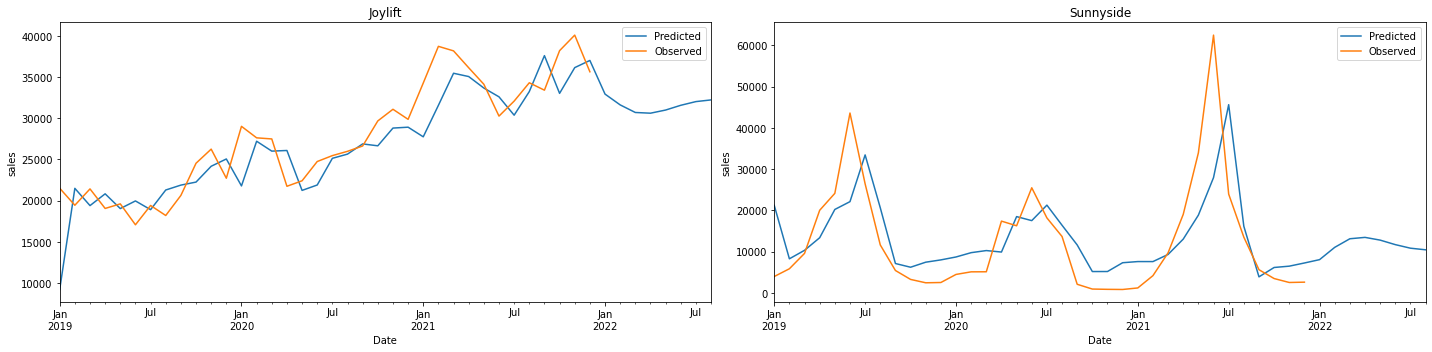

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

def plot_results(cols, axes, preds):
    axes = np.hstack(axes)
    for ax, col in zip(axes, cols):
        preds[col].plot(ax=ax, label="Predicted")
        sales_insights_bottom_level[col].plot(ax=ax, label="Observed")

        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("sales")
    
plot_results(brands, axes, predicted_autoarima)
plt.tight_layout()

Of course, you can also check results for specific, nodes, let's get for OTH:

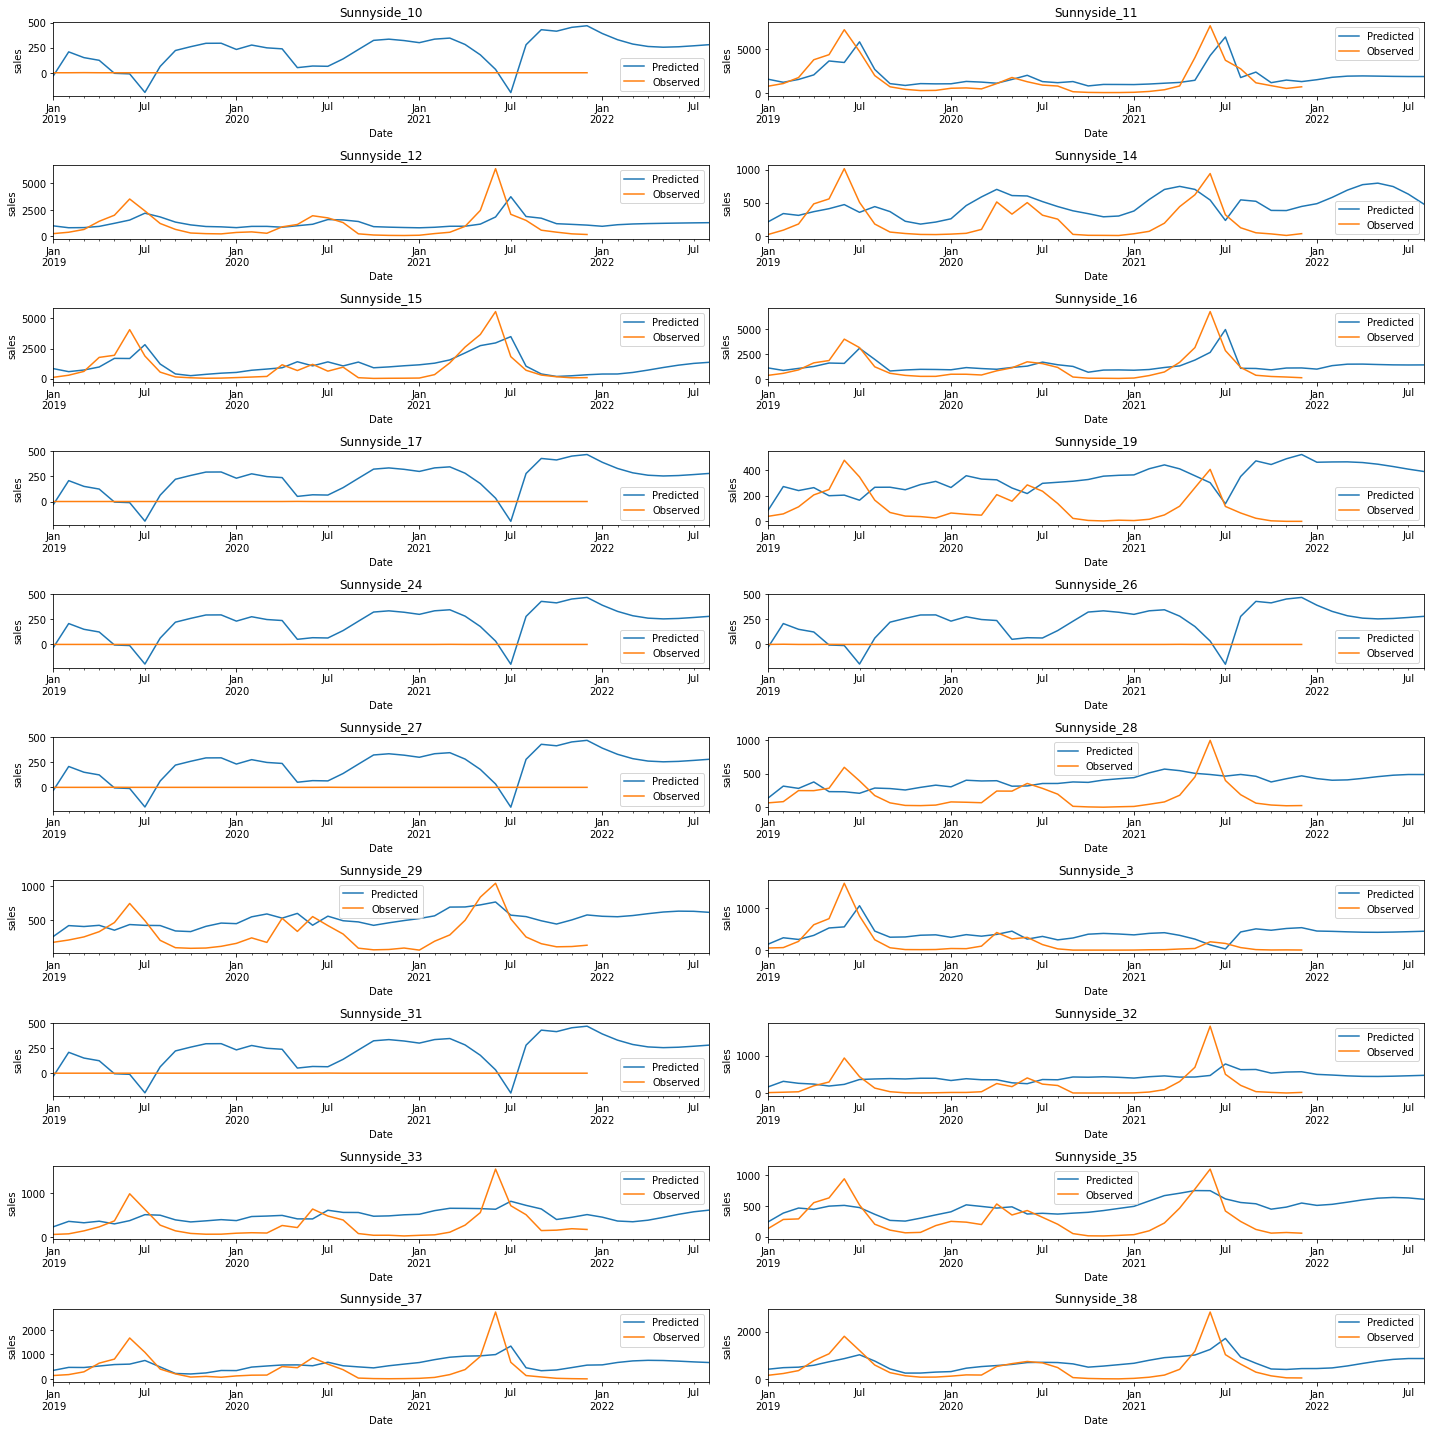

In [25]:
fig, axes = plt.subplots(10, 2, figsize=(20, 20))
plot_results(brand_cols, axes, predicted_autoarima)
plt.tight_layout()

### Prophet

We can do the same fit as above, but now for prophet model.

In [26]:
clf = HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)
model = clf.fit(sales_insights_bottom_level, hierarchy) 

Fitting models:   0%|          | 0/89 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   1%|          | 1/89 [00:02<03:16,  2.23s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   2%|▏         | 2/89 [00:02<02:30,  1.73s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   3%|▎         | 3/89 [00:03<01:55,  1.34s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasona

In [27]:
predicted_prophet = model.predict(steps_ahead=12)

Fitting models: 100%|██████████| 89/89 [02:42<00:00,  1.83s/it]


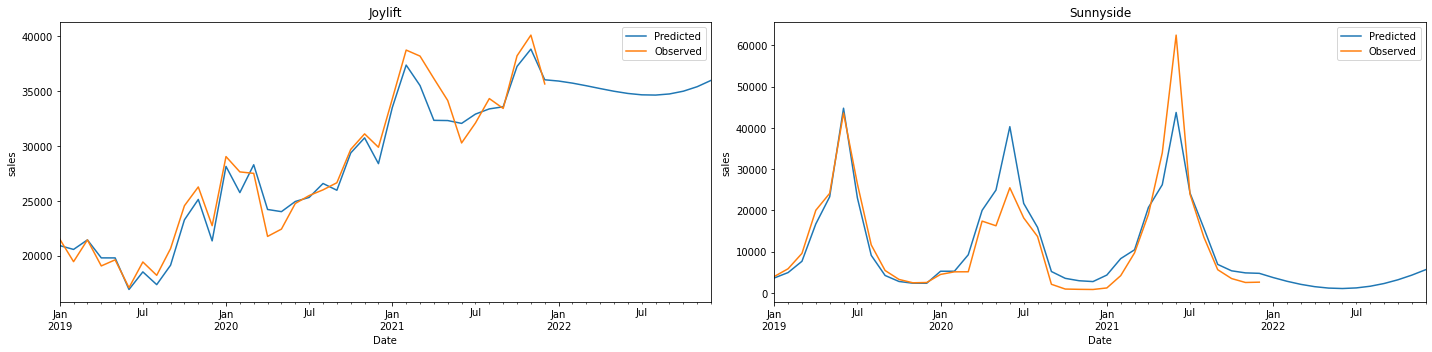

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
plot_results(brands, axes, predicted_prophet)
plt.tight_layout()

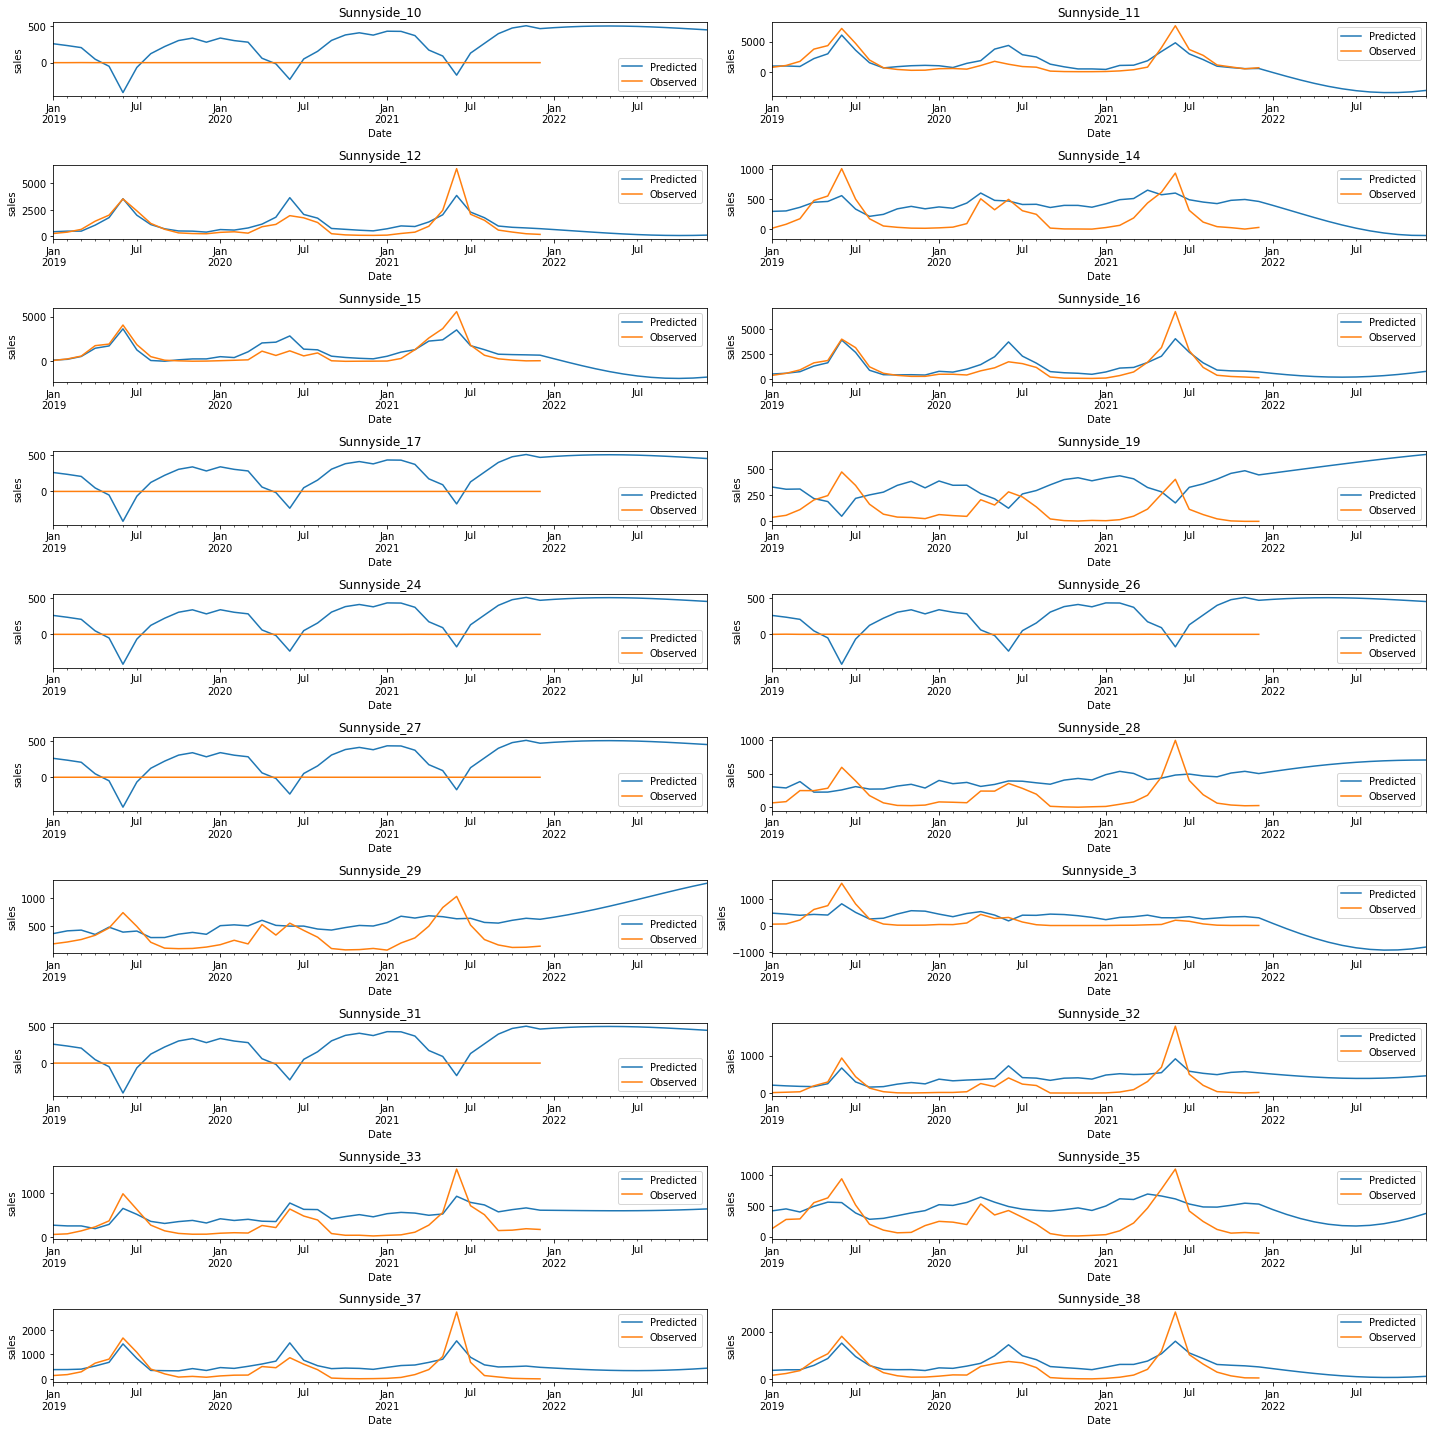

In [29]:
fig, axes = plt.subplots(10, 2, figsize=(20, 20))
plot_results(brand_cols, axes, predicted_prophet)
plt.tight_layout()